## Question-1
### Ingest and perform analytics over Yelp open dataset (Json format) from https://www.yelp.com/dataset to a data store (NoSQL or RDBMS) in your local laptop or Cloud. You may have troubles with the large data volume. 

In [2]:
import os
import pandas as pd
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_Dataset')

In [5]:
import sqlite3
import json
from datetime import datetime


sql_transaction = []
import pymysql.cursors
# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='Diven08*',
                             db='lift&co',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
                             

c = connection.cursor()

def transaction_bldr(query, data):
    global sql_transaction
    singleTransaction = (query, data)
    sql_transaction.append(singleTransaction)
    if len(sql_transaction) > 500:
        for s in sql_transaction:
            tempData = s[1]
            try:
                c.execute(s[0],tempData)
                
            except Exception as e:
                print(e)
                
        connection.commit()
        sql_transaction = []
        return 



def create_tables():
    c.execute("""CREATE TABLE IF NOT EXISTS reviews ( `review_id` VARCHAR(250) ,`user_id` VARCHAR(250), `business_id` VARCHAR(250), `text` TEXT, `date` VARCHAR(50) )""")
    c.execute("CREATE TABLE IF NOT EXISTS check_in(business_id VARCHAR(250) PRIMARY KEY, date LONGTEXT)")
    c.execute("""CREATE TABLE IF NOT EXISTS busines ( `business_id` VARCHAR(250) ,`name` VARCHAR(250), `city` VARCHAR(250), `state` VARCHAR(250), `review_count` int, `stars` int, `is_open` boolean, `attributes` TEXT, `categories` TEXT )""")
    c.execute("""CREATE TABLE IF NOT EXISTS users ( `user_id` VARCHAR(250) ,`since` VARCHAR(250), `useful` int, `review_count` int, `average_stars` int, `friends` TEXT, `fans` TEXT )""")
    c.execute("""CREATE TABLE IF NOT EXISTS photos ( `business_id` VARCHAR(250) ,`photo_id` VARCHAR(250),`caption` VARCHAR(250),`label` VARCHAR(25) )""")
    c.execute("""CREATE TABLE IF NOT EXISTS tip ( `user_id` VARCHAR(250) ,`business_id` VARCHAR(250) ,`text` TEXT, `date` VARCHAR(50), `compliment_count` int )""")
    
def sql_insert_row(table_name, data):
    insert_query = """INSERT INTO {} VALUES ( """.format(table_name)
    firstRecord = True
    for record in data:
        if not firstRecord:
            insert_query = insert_query + " , "
        insert_query = insert_query + "%s"
        firstRecord = False
    insert_query = insert_query + ");"
   # try:
    transaction_bldr(insert_query, data)

if __name__ == '__main__':
    create_tables()
    row_counter = 0
    tableDataMap = {

"check_in" : {
            "file" : "checkin.json",
            "columns" : ["business_id", "date"]
        },
"photos" : {
            "file" : "photo.json",
            "columns" : ["business_id", "photo_id", "caption", "label" ]
        },
"tip" : {
            "file" : "tip.json",
            "columns" : ["user_id", "business_id", "text", "date" ,"compliment_count"]
        },
"users" : {
            "file" : "user.json",
            "columns" : ["user_id", "since", "useful", "review_count", "average_stars", "frineds", "fans" ]
        },
"busines" : {
            "file" : "business.json",
            "columns" : ["business_id", "name", "city", "state", "review_count", "stars", "is_open", "attributes", "categories" ]
        },
"reviews" : {
            "file" : "review.json",
            "columns" : ["review_id","user_id", "business_id", "text", "date" ]
        }

    }
    for tableName, fileAndColumnMap in tableDataMap.items():
        with open(fileAndColumnMap.get("file"), buffering=1000) as f:
            for row in f:
                row_counter += 1
                row = json.loads(row)
                tempRowData = []
                for columnName in fileAndColumnMap.get("columns"):
                    try:
                        singleData = row[columnName]
                    except Exception as e:
                        singleData = ""


                    tempRowData.append(str(singleData))
                sql_insert_row(tableName, tempRowData)
                if row_counter % 10000 == 0:
                    print('Total Rows Read: {}, Time: {}'.format(row_counter, str(datetime.now())))
        print("done")
        connection.commit()
    c.close()

Total Rows Read: 10000, Time: 2019-11-02 15:35:19.131377
Total Rows Read: 20000, Time: 2019-11-02 15:35:24.262738
Total Rows Read: 30000, Time: 2019-11-02 15:35:31.300813
Total Rows Read: 40000, Time: 2019-11-02 15:35:36.996653
Total Rows Read: 50000, Time: 2019-11-02 15:35:43.353801
Total Rows Read: 60000, Time: 2019-11-02 15:35:50.159965
Total Rows Read: 70000, Time: 2019-11-02 15:35:56.571436
Total Rows Read: 80000, Time: 2019-11-02 15:36:02.878728
Total Rows Read: 90000, Time: 2019-11-02 15:36:08.247433
Total Rows Read: 100000, Time: 2019-11-02 15:36:13.568287
Total Rows Read: 110000, Time: 2019-11-02 15:36:19.504173
Total Rows Read: 120000, Time: 2019-11-02 15:36:25.603002
Total Rows Read: 130000, Time: 2019-11-02 15:36:31.719269
Total Rows Read: 140000, Time: 2019-11-02 15:36:38.306858
Total Rows Read: 150000, Time: 2019-11-02 15:36:43.619157
Total Rows Read: 160000, Time: 2019-11-02 15:36:48.779374
done
Total Rows Read: 170000, Time: 2019-11-02 15:36:52.910552
Total Rows Read: 1

In [ ]:
#23 mins for first 5 tables
#50 mins for review table

## Question-2
### Top 10 restaurants in Toronto with the highest popularity. You are free to define your ‘popularity’, as long as it can convince people.

### Popularity is defined by the maximum footfall in the restaurant or we can say the total count of check-in

#### Loading required libraries

In [2]:
import os
import pandas as pd
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_Dataset')

#### Reading check-in table

In [2]:
#business_id,name,city,state,review_count,is_open
import json
import pandas as pd
import matplotlib.pyplot as plt


# open input file: 
ifile = open('checkin.json') 

stop = -1

all_data = list()
for i, line in enumerate(ifile):
    if i%100000==0:
        print(i)
    if i==stop:
        break    
    # convert the json on this line to a dict
    data = json.loads(line)
    # extract what we want
    business_id = data['business_id']
    date = data['date']

    counter = 0
    try:
        datelist = date.split(",")
        for d in datelist:
            d = d.replace(" ","")
            counter+=1
    except Exception as e:
        pass
    
    all_data.append([business_id,counter])
       

    
# create the DataFrame
check_in = pd.DataFrame(all_data, columns=['business_id','date'])

ifile.close()
#check_in.to_csv("check_in_count.csv",index=False)


0
100000


#### Joining business table with check-in table

In [3]:
business = pd.read_csv("business.csv")
check_in = pd.read_csv("check_in_count.csv")

#Join
temp = business.merge(check_in, how='left')


#### Filtering out restaurant which are in Toronto and sorting it by check-in count

In [4]:
#Filter out only Toronto
toronto = temp[business['city'] == "Toronto"]

#Sort by the count of dates
#date is the count of checkin
toronto = toronto.sort_values('date', ascending = False)

#Saivng it into csv
#toronto.to_csv("toronto-1.csv",index=False)

#### Showing the top 10 popular restaurants of Toronto

In [8]:
value = 10
toronto.sort_values(by = 'date', ascending = False)[:value]

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude,date
49253,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,Toronto,ON,2121,1,"Restaurants, Food, Thai, Ethnic Food, Specialt...",43.647866,-79.388642,2872.0
9593,nT16Y6AsJDwEpUB1JICKzg,St Lawrence Market,Toronto,ON,496,1,"Farmers Market, Restaurants, Grocery, Sandwich...",43.648730,-79.371541,2221.0
56542,trKyIRyjKqVSZmcU0AnICQ,Pearl Diver,Toronto,ON,517,1,"Chinese, Steakhouses, Seafood, Breakfast & Bru...",43.651539,-79.373760,2193.0
28283,e41TP5cXZqSrz50xCBJqZw,Insomnia Restaurant & Lounge,Toronto,ON,795,1,"French, Bars, Caterers, Canadian (New), Breakf...",43.665131,-79.410852,2173.0
38605,N93EYZy9R0sdlEvubu94ig,Banh Mi Boys,Toronto,ON,1045,1,"Sandwiches, Restaurants, Asian Fusion, Food, D...",43.648827,-79.396970,1816.0
69093,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,Toronto,ON,1397,1,"Bars, Restaurants, Japanese, Tapas/Small Plate...",43.660430,-79.378927,1723.0
41632,f5O7v_X_jCg2itqacRfxhg,Sansotei Ramen,Toronto,ON,794,1,"Restaurants, Ramen, Japanese, Noodles",43.655004,-79.386473,1720.0
68180,-av1lZI1JDY_RZN2eTMnWg,Salad King Restaurant,Toronto,ON,876,1,"Thai, Restaurants",43.657648,-79.381728,1714.0
63110,aLcFhMe6DDJ430zelCpd2A,Khao San Road,Toronto,ON,1410,1,"Thai, Restaurants",43.646411,-79.393480,1713.0
65700,DE89UdHFMCN6DtYWZuer5A,Hokkaido Ramen Santouka,Toronto,ON,750,1,"Japanese, Restaurants, Noodles, Ramen",43.656322,-79.377500,1707.0


## Question-3
### How many Canadian residents(figure out who are Canadian residents by yourself) reviewed the business “Mon Ami Gabi” in last 1 year?

In [1]:
import os
import pandas as pd
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_Dataset')

In [2]:
reviews = pd.read_csv("reviews.csv")
business = pd.read_csv("business.csv")

In [3]:
reviews.head()

,Review_id,User_id,business_id,stars,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,IPw8yWiyqnfBzzWmypUHgg,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,If you are looking for the best pierogies in P...,2017-05-13 10:41:43
2,eed44nI0eZ4BGKtKXsRJhQ,tAcB1ZohRtjozsymvqqHzQ,m7ommfJFalI47UksyX04Iw,1.0,Met a friend for dinner there tonight. The ser...,2014-09-25 08:15:44
3,E4LqIZ7DJd_R4ZHSNKx4RQ,DoRCeCcJbrsM2BiAKj3trA,SU56w479vUfFHsvmvQIf7A,4.0,So good! They didn't make it to 5 stars due to...,2016-07-25 03:55:20
4,h7Rmb3EiXjajVfGYNa5CuQ,oAOE4UAC5ZbAjEGBEMCb4g,PycR_Mr5jA9jB4Xg3nX0Yw,1.0,They charged me twice what I expected to pay. ...,2014-01-17 02:15:25


In [4]:
business.head()

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",43.605499,-79.652289
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,170,1,"Sushi Bars, Restaurants, Japanese",35.092564,-80.859132
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,18,1,"Restaurants, Breakfast & Brunch, Mexican, Taco...",33.495194,-112.028588
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,16,1,"Italian, Restaurants, Pizza, Chicken Wings",41.708520,-81.359556
4,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,Willoughby,OH,7,1,"Bakeries, Food",41.639860,-81.406396


### Finding all those users who reviewed Mon Ami Gabi

In [5]:
business[business['name'] == 'Mon Ami Gabi']


,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
31832,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,Las Vegas,NV,8348,1,"Food, French, Breakfast & Brunch, Restaurants,...",36.112859,-115.172434


In [6]:
mon_ami_gabi = reviews[reviews['business_id'] == "4JNXUYY8wbaaDmk3BPzlWw"]
#mon_ami_gabi.to_csv("mon_ami_gabi.csv",index=False)

mon_ami_gabi

,Review_id,User_id,business_id,stars,text,date
101093,BP-Ef0N-DwVzRLOhESrSkw,SIpBqzGhRM7T5cDFiuIryg,4JNXUYY8wbaaDmk3BPzlWw,5.0,"I finally ate here today! For many years, I w...",2013-10-25 02:00:20
101477,lV4-_fa-Xx8ar1Ke80m3Rg,0hMC8tPtc_K_ACAj7pss_Q,4JNXUYY8wbaaDmk3BPzlWw,3.0,"What I loved about this place is that, when I ...",2011-04-25 06:35:05
101487,CgNoFiHxxZE8dn-vULYB9Q,HFECrzYDpgbS5EmTBtj2zQ,4JNXUYY8wbaaDmk3BPzlWw,4.0,"When I'm on a business trip, it's easier to ea...",2012-03-03 00:24:57
101820,z_X2-0bK9K8dUpGHzgsHBg,gDXJ1ES0-IQ_6T7a7oOjwg,4JNXUYY8wbaaDmk3BPzlWw,4.0,"There's a nice evening breeze, you can hear An...",2013-02-23 09:36:48
101921,stKtPWHBi3UCaU88MBWdhQ,DlVTMl3ciFqguGb5hWjswg,4JNXUYY8wbaaDmk3BPzlWw,4.0,"Nice view, decent food (but can be hit or miss...",2014-04-03 10:24:30
...,...,...,...,...,...,...
123052,cmAWxw_cpORuHB9s3Qt2cw,DjiWvNLBbrOI5qKOyYGtCA,4JNXUYY8wbaaDmk3BPzlWw,5.0,I am so happy i found got to try this amazing ...,2012-10-06 16:41:48
123865,a9hEUNGI9A-hgZzki1U2ZA,41HLwXnR0Lm3NUp01cIOQg,4JNXUYY8wbaaDmk3BPzlWw,3.0,Food at Mon Ami Gabi is decent and the view to...,2011-03-15 07:58:48
124679,pj40n3BEe5G7vo5pVocpgA,NE0Mx9NLNUi9eVUpM5v1Gw,4JNXUYY8wbaaDmk3BPzlWw,5.0,Strolled in around 10 AM on a Sunday morning. ...,2014-09-23 22:23:30
124722,HOrSUjqwQq0S1lgRN6rUKw,lxdiwASOCnvRFsogbEYh3A,4JNXUYY8wbaaDmk3BPzlWw,4.0,"This place started on the wrong foot, but once...",2016-10-24 07:39:49


In [7]:
mon_ami_gabi = pd.read_csv("mon_ami_gabi.csv")

In [8]:
print(min(mon_ami_gabi['date']))
print(max(mon_ami_gabi['date']))

2008-10-27 20:53:20
2018-10-09 02:01:48


### Filtering out those users who reviewed in last 1 year

In [12]:
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
currTime = datetime.now()

year_value = 1

#Set value of years
deltaDate = currTime - relativedelta(years=year_value)

dateb = str(deltaDate)

In [13]:
mon_ami_gabi_2018 = mon_ami_gabi[mon_ami_gabi['date'] > dateb]

In [14]:
print("Number of reviews:",len(mon_ami_gabi_2018))
print(min(mon_ami_gabi_2018['date']))
print(max(mon_ami_gabi_2018['date']))

Number of reviews: 0


ValueError: min() arg is an empty sequence

### Filtering out those users who reviewed in last 3 years

In [9]:
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
currTime = datetime.now()

year_value = 3

#Set value of years
deltaDate = currTime - relativedelta(years=year_value)

dateb = str(deltaDate)

In [10]:
mon_ami_gabi_2018 = mon_ami_gabi[mon_ami_gabi['date'] > dateb]

In [11]:
print("Number of reviews:",len(mon_ami_gabi_2018))
print(min(mon_ami_gabi_2018['date']))
print(max(mon_ami_gabi_2018['date']))

Number of reviews: 26
2016-11-12 19:24:38
2018-10-09 02:01:48


In [12]:
mon_ami_gabi_2018

,Review_id,User_id,business_id,stars,text,date
5,04CwiR2yH0w0GbqxDIkZsw,a2r5WiBx5hehodpEgIT3_A,4JNXUYY8wbaaDmk3BPzlWw,5.0,"After about EIGHT visits, this deserves a FIVE...",2018-08-05 19:06:21
8,eExq38cLw-c7C4_F3lwDlg,WP9NaEgjvpsjTtZESisRLA,4JNXUYY8wbaaDmk3BPzlWw,5.0,Redemption.\nBrunch at Mon Ami Gabi.\nWe had a...,2018-08-15 16:36:06
12,NFfEEQHhX1ot9uwEwqDhuQ,61AymMi8D4RTQ2aa1w41ew,4JNXUYY8wbaaDmk3BPzlWw,4.0,Great service and food. There is tons to choos...,2018-05-20 13:57:38
18,R3eGyKESUsz0frN0Yl4nxg,XMgSvrWrkuVRua-M2XPRqg,4JNXUYY8wbaaDmk3BPzlWw,5.0,Thought we'd try their brunch as we always eat...,2016-11-12 19:24:38
25,ZVozR2EqKhZSlgSYhA8i3g,jnKAhw3A9ASM3Nn9wXdA6A,4JNXUYY8wbaaDmk3BPzlWw,5.0,This was the best restaurant we ate at while i...,2017-03-07 17:23:21
38,JX2Hmwv7bLpGpbn_iyTDTA,NhgU7RhuYYFmpkb1jlYJ6Q,4JNXUYY8wbaaDmk3BPzlWw,4.0,"Collectively, all of my visits here have been ...",2017-10-15 21:45:59
42,UG20AeOKIV-_eQj2y72wXA,D9ATcRG8pld4ZQXVW6SG0g,4JNXUYY8wbaaDmk3BPzlWw,4.0,I came here on my birthday and ordered the esc...,2017-01-09 22:56:10
45,WO6Tp5d8eI09GI49luPZyg,YMYb73K3Dv3oiac4mADJSg,4JNXUYY8wbaaDmk3BPzlWw,5.0,"Perfect, again.\n\nCame back here with friends...",2018-01-28 01:25:04
46,Qzb7taWccqobs0pXWb5wfA,xSmJ4WZCxnLePHIM95ZhcQ,4JNXUYY8wbaaDmk3BPzlWw,4.0,Here's a great place you will actually get exc...,2018-09-30 22:32:18
50,P7b_LWkgRsUKLDl82swv_w,-RApyq06DMBii7ovXtQnfw,4JNXUYY8wbaaDmk3BPzlWw,4.0,One of the places I recommend for first timers...,2018-05-03 06:07:51


### FInding Canadian Customers

In [13]:
t_review = pd.read_csv("reviews.csv")
t_business = pd.read_csv("business.csv")

In [14]:
t_review_merge = t_review.merge(t_business, how='left')
t_review_merge

,Review_id,User_id,business_id,stars,text,date,name,city,state,review_count,is_open,categories,latitude,longitude
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IPw8yWiyqnfBzzWmypUHgg,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,If you are looking for the best pierogies in P...,2017-05-13 10:41:43,Pierogies Plus,McKees Rocks,PA,74.0,1.0,"Caterers, Polish, Event Planning & Services, R...",40.468871,-80.059936
2,eed44nI0eZ4BGKtKXsRJhQ,tAcB1ZohRtjozsymvqqHzQ,m7ommfJFalI47UksyX04Iw,1.0,Met a friend for dinner there tonight. The ser...,2014-09-25 08:15:44,The Palomino,Calgary,AB,112.0,1.0,"Restaurants, Music Venues, Arts & Entertainmen...",51.046466,-114.063533
3,E4LqIZ7DJd_R4ZHSNKx4RQ,DoRCeCcJbrsM2BiAKj3trA,SU56w479vUfFHsvmvQIf7A,4.0,So good! They didn't make it to 5 stars due to...,2016-07-25 03:55:20,India Oven,Las Vegas,NV,133.0,0.0,"Restaurants, Indian, Pakistani",36.144700,-115.155176
4,h7Rmb3EiXjajVfGYNa5CuQ,oAOE4UAC5ZbAjEGBEMCb4g,PycR_Mr5jA9jB4Xg3nX0Yw,1.0,They charged me twice what I expected to pay. ...,2014-01-17 02:15:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248428,gupUBwWRb13IvQhlKd6wdg,KodWdOaE1D4TloVSK0rXpg,cZahCTPCJdorOWB6R7EgiA,5.0,We had great experience with quest limos this ...,2014-04-20 06:09:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248429,828Gi_ZVcfO7-PR84DZZOw,PMttXkZ0XQwrUyUyjRtvzQ,t8L09GiwLH3cuJPQjPzZaA,5.0,The best school for dealer training around. Pr...,2018-09-13 00:51:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248430,NLhVwKW2uNgK4GZrDiaQug,73102fWuyLRHVWLK6_UqrQ,T-eEjmbEeQ53ezioW_9vxQ,1.0,Was insulted after enjoying a meal with my wif...,2015-04-07 17:57:29,Phil's Italian Steak House,Las Vegas,NV,160.0,1.0,"Nightlife, Hotels & Travel, Restaurants, Arts ...",36.124571,-115.172428
248431,_VWXElLV_nzUQnkddLMc8g,5FAD2Yq7DLBQ_-ef1iDA-A,ndTgznMYNe0n26VqzecEKQ,5.0,I needed an older sectional cleaned and yelp s...,2018-07-22 04:17:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Table-1: Number of reviews given by every user

In [15]:
#count of every user in t_review_merge

temp = t_review_merge.groupby(['User_id']).count()

temp['User'] = temp.index
#temp=pd.read_csv("count_of_reviews_all.csv")
temp

,Review_id,business_id,stars,text,date,name,city,state,review_count,is_open,categories,latitude,longitude,User
User_id,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,14,14,14,14,14,4,4,4,4,4,4,4,4,---1lKK3aKOuomHnwAkAow
--4rAAfZnEIAKJE80aIiYg,1,1,1,1,1,1,1,1,1,1,1,1,1,--4rAAfZnEIAKJE80aIiYg
--5XzJ2pRsVVJiJUfzZlgQ,1,1,1,1,1,0,0,0,0,0,0,0,0,--5XzJ2pRsVVJiJUfzZlgQ
--7gjElmOrthETJ8XqzMBw,1,1,1,1,1,1,1,1,1,1,1,1,1,--7gjElmOrthETJ8XqzMBw
--Nnm_506G_p8MxAOQna5w,1,1,1,1,1,0,0,0,0,0,0,0,0,--Nnm_506G_p8MxAOQna5w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzjKekzQ6i4iR-qpo405Pw,1,1,1,1,1,0,0,0,0,0,0,0,0,zzjKekzQ6i4iR-qpo405Pw
zzjQuRnY_Kgr_zaw6A-ACQ,1,1,1,1,1,0,0,0,0,0,0,0,0,zzjQuRnY_Kgr_zaw6A-ACQ
zzo--VpSQh8PpsGVeMC1dQ,9,9,9,9,9,8,8,8,8,8,8,8,8,zzo--VpSQh8PpsGVeMC1dQ


#### Table-2 : Number of users who gave review to any restaurant in Canada

In [16]:
#Canada States
states = ["AB", "BC", "MB", "NB", "NL", "NT", "NS", "NU", "ON", "PE", "QC", 
          "SK", "YT"]

#Filtering out the data of Canada from the main merged table
canada=t_review_merge.loc[t_review_merge['state'].isin(states)]

#Getting the count of total number of reviews of every user who reviewd any Canadian Restaurant
canada = canada.groupby(['User_id']).count()
canada['User'] = canada.index
print("There are {} users who have reviewd Canadian Restaurant:".format(len(canada)))

#canada.to_csv("count_of_reviews_canada.csv",index=True)
#canada=pd.read_csv("count_of_reviews_all.csv")
canada

There are 8296 number of users who have reviewd Canadian Restaurant:


,Review_id,business_id,stars,text,date,name,city,state,review_count,is_open,categories,latitude,longitude,User
User_id,,,,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,1,1,1,1,1,1,1,1,1,1,1,1,1,--7gjElmOrthETJ8XqzMBw
--Qh8yKWAvIP4V4K8ZPfHA,10,10,10,10,10,10,10,10,10,10,10,10,10,--Qh8yKWAvIP4V4K8ZPfHA
--YhjyV-ce1nFLYxP49C5A,1,1,1,1,1,1,1,1,1,1,1,1,1,--YhjyV-ce1nFLYxP49C5A
-06AUDaZG_VaSVugGvPd0A,1,1,1,1,1,1,1,1,1,1,1,1,1,-06AUDaZG_VaSVugGvPd0A
-0SqALqeWmInVftG_iHcHg,1,1,1,1,1,1,1,1,1,1,1,1,1,-0SqALqeWmInVftG_iHcHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwmThlRiY1LHfJ_7zNfGqg,1,1,1,1,1,1,1,1,1,1,1,1,1,zwmThlRiY1LHfJ_7zNfGqg
zwwJklnKoi_tPG5V7MNk0w,1,1,1,1,1,1,1,1,1,1,1,1,1,zwwJklnKoi_tPG5V7MNk0w
zyeSJYZ1TDzRe2YLefcwMQ,1,1,1,1,1,1,1,1,1,1,1,1,1,zyeSJYZ1TDzRe2YLefcwMQ


#### Joining both the tables and finding out the common users

In [17]:
all =  pd.read_csv("count_of_reviews_all.csv")
canada = pd.read_csv("count_of_reviews_canada.csv")

In [18]:
temp = pd.merge(all, canada, how='inner', on=['User_id'])

In [19]:
temp = temp[['User_id','Review_id_x','Review_id_y']]
temp.columns = ['User_id','all','canada']
temp

,User_id,all,canada
0,--7gjElmOrthETJ8XqzMBw,1,1
1,--Qh8yKWAvIP4V4K8ZPfHA,21,10
2,--YhjyV-ce1nFLYxP49C5A,1,1
3,-06AUDaZG_VaSVugGvPd0A,1,1
4,-0SqALqeWmInVftG_iHcHg,3,1
...,...,...,...
8291,zwmThlRiY1LHfJ_7zNfGqg,1,1
8292,zwwJklnKoi_tPG5V7MNk0w,1,1
8293,zyeSJYZ1TDzRe2YLefcwMQ,1,1
8294,zzo--VpSQh8PpsGVeMC1dQ,9,7


#### Calculating the % of the total reviews a user has given in Canada

In [20]:
temp['canada_per'] = temp['canada'] / temp['all'] *100
temp

,User_id,all,canada,canada_per
0,--7gjElmOrthETJ8XqzMBw,1,1,100.000000
1,--Qh8yKWAvIP4V4K8ZPfHA,21,10,47.619048
2,--YhjyV-ce1nFLYxP49C5A,1,1,100.000000
3,-06AUDaZG_VaSVugGvPd0A,1,1,100.000000
4,-0SqALqeWmInVftG_iHcHg,3,1,33.333333
...,...,...,...,...
8291,zwmThlRiY1LHfJ_7zNfGqg,1,1,100.000000
8292,zwwJklnKoi_tPG5V7MNk0w,1,1,100.000000
8293,zyeSJYZ1TDzRe2YLefcwMQ,1,1,100.000000
8294,zzo--VpSQh8PpsGVeMC1dQ,9,7,77.777778


#### Setting up some conditions to define a user to be Canadian

In [21]:
#Minimum reviews in Canada = 5.
#75% of reviews should be in Canada.

min_reviews = 5
cut_off = 75

In [22]:
x = temp[temp['canada'] > min_reviews]
x.sort_values(by = 'canada')

,User_id,all,canada,canada_per
6652,nOSWGrjT4HIpDohLAOpgLw,7,6,85.714286
6125,jDzGfjwSYZZsQ7nNNnzJ3Q,10,6,60.000000
6179,jfUTkA8sIhiw5ahn9-9HPg,9,6,66.666667
6191,jn5mjTce7_zDYNiGL5ojTA,8,6,75.000000
2229,FmfXYGze3qpuSU-wj4rK5w,7,6,85.714286
...,...,...,...,...
3281,O3q-nwYZykMmacxjru01Zg,145,129,88.965517
1112,7Ri5xkuj6rMvD8F2zjWFow,145,134,92.413793
4389,Wc5L6iuvSNF5WGBlqIO8nw,371,277,74.663073
3553,Q9mA60HnY87C1TW5kjAZ6Q,509,341,66.994106


In [23]:
y = x[x['canada_per'] > cut_off]
#y.to_csv("canadian_users.csv", index = False)
y.sort_values(by = 'canada_per', ascending=False)

,User_id,all,canada,canada_per
2388,GqLTKz0YsSkX-DTc9oHrBg,16,16,100.000000
6812,oW9PoxLCSMwZ6EEjKuPNjw,8,8,100.000000
2910,L1xB30wQZaMWdCR9M87lUA,7,7,100.000000
6452,lstlOQgPI-HEmvf85yAA5A,7,7,100.000000
6456,ludl6VlDreQcK4ZgOxo5Sg,6,6,100.000000
...,...,...,...,...
7403,t2O6rs4fZeY9o6ZY52RyJA,21,16,76.190476
1900,DBHCFW3mSmmOEpONHVu1rQ,25,19,76.000000
3753,ReDypdRmVA3wc-QG8HBKkQ,37,28,75.675676
4076,U95wccXN_J8JwA5Ktlu8tw,41,31,75.609756


In [24]:
len(y) / len(temp) *100

3.7970106075216976

#### As per the criteria initalized above, only 315 users (~3.8%) of the total users are Canadian

In [25]:
canadian_users = pd.read_csv("canadian_users.csv")
canadian_users

,User_id,all,canada,canada_per
0,-UgKXdXQPjfltffd2e5SPQ,9,8,88.888889
1,-m0KTRk0c901-4b-BN34Gg,9,8,88.888889
2,0IwZb1ePNpSVYcCdMtGoQw,78,78,100.000000
3,0J9mtVJ4_QGsXYVK8qJzOQ,50,42,84.000000
4,0Se8OFrPpi6wE2TY2IVTLA,13,13,100.000000
...,...,...,...,...
310,zLuX_g-whSejuUGTKW8PTw,12,12,100.000000
311,zPadAb9MnwcSHiwcUtAlIg,6,6,100.000000
312,zRMYkKuolr9hgaYixFm1NA,7,7,100.000000
313,zopuXHE12sjKeSukIv6Axg,27,25,92.592593


### Now as we have a list of Canadian users and list of users who reviewed Mon Ami Gabi, Let's find out how many Canadian users reviewed it.

In [26]:
canadian_mon_ami_gabi = pd.merge(mon_ami_gabi_2018, canadian_users, how='inner', on=['User_id'])

In [30]:
len(canadian_mon_ami_gabi)

0

# Qusetion-4
### Top 10 most common words in the reviews of the business “Chipotle Mexican Grill” might be helpful and interesting to the business.

In [1]:
import os
import pandas as pd
import nltk
pd.options.display.max_colwidth = 50
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_dataset')

### Reading Business Table

In [2]:
df=pd.read_csv('business.csv')

In [3]:
df.head()

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",43.605499,-79.652289
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,170,1,"Sushi Bars, Restaurants, Japanese",35.092564,-80.859132
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,18,1,"Restaurants, Breakfast & Brunch, Mexican, Taco...",33.495194,-112.028588
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,16,1,"Italian, Restaurants, Pizza, Chicken Wings",41.708520,-81.359556
4,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,Willoughby,OH,7,1,"Bakeries, Food",41.639860,-81.406396


### Filtering out all the branches of Chipotle Mexican Grill if any.

In [4]:
cmg = df[df['name']=='Chipotle Mexican Grill']

In [5]:
cmg.count()

business_id     183
name            183
city            183
state           183
review_count    183
is_open         183
categories      183
latitude        183
longitude       183
dtype: int64

#### There are 183 brnaches of Chipotle Mexican Grill

In [6]:
cmg.head()

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
214,dusNIzdCaH6EoLl2hRy6cQ,Chipotle Mexican Grill,Las Vegas,NV,115,1,"Fast Food, Mexican, Restaurants",36.120095,-115.171769
650,_EVOLAjWYEfSOO_smbBxaA,Chipotle Mexican Grill,Wexford,PA,19,1,"Restaurants, Mexican, Fast Food",40.623071,-80.054498
853,0rN_o7_IfshAHQwzMUK8nA,Chipotle Mexican Grill,Solon,OH,57,1,"Restaurants, Mexican, Fast Food",41.385342,-81.440624
1337,8Rydf8hXleCwbCN9nvmZ4Q,Chipotle Mexican Grill,Madison,WI,41,1,"Fast Food, Restaurants, Mexican",43.075147,-89.396568
1441,VFv7NcPW9ajUTLleJ8wOQA,Chipotle Mexican Grill,Pittsburgh,PA,65,1,"Mexican, Fast Food, Restaurants",40.441062,-79.957998


In [7]:
id = list(cmg['business_id'])

In [9]:
id

['dusNIzdCaH6EoLl2hRy6cQ',
 '_EVOLAjWYEfSOO_smbBxaA',
 '0rN_o7_IfshAHQwzMUK8nA',
 '8Rydf8hXleCwbCN9nvmZ4Q',
 'VFv7NcPW9ajUTLleJ8wOQA',
 'NbkDsQhfK13ATV79TI4OQg',
 'Nb3hAuv8OkpFgSImYdt3Rg',
 'A8MmwHrMI0WnRTyQMdf8aQ',
 'EozEGL29WftitEANtx3vaw',
 'HPngBhTmMOXbQI9Noppeaw',
 'AUl6myFhTAbEqt0GMdKHiw',
 '426RL7G7oTyu-f8jFxVRJQ',
 'T1lOHMIas_PSflKY7duF_g',
 'qUqmTlchliF55jF7s4Xlmw',
 'DG8KlNP7ArYesQb2AGUHng',
 'zMPfZdODe82SL_zxnv7asg',
 '3btAvuu-3hjq9UUa5FO-9Q',
 'Gl01qPpjC9DKN_Py3IEnpA',
 '4w3CXzYFboPjsjDHIXyVLg',
 'wy6pYrWtiGrktOpUmsvCHQ',
 'wAXYLmHuysYTz8i4VPKmaQ',
 'xsdRrNJuNumvrwoQ2Tt8tQ',
 'QnCsCbE7EQte_MDWLO1gYg',
 'KiTHWMK20GvgPvpHSzTHTg',
 'pIhteCW9zwjWzemoJwm4lw',
 '1D-7VH5nJdgjdjK5RAO28Q',
 '9qqhdkN4aeE6yvUiKg4F0Q',
 'kOmz-QnNWTZJMws-qH3eEw',
 'POIowl4F1ZiHdKLnx__ulw',
 'nEIWxj6m1gGWe1gi596Zvg',
 'sNAU_ItzmB-TIgmWwqRlEw',
 '-FNquqGseSCVMWo7KbK-Tg',
 'TTnUoYDCQoTfldLs3AuTDg',
 '-QC71Wuh0TyJI0RAZ3d0Iw',
 'Ks9nrEuLdjmrLH9uXz_G8A',
 '-FyfimfMvvOcMT7Cr4q2Aw',
 'WYDjn71X5xiEdpLxlT12hQ',
 

### Filtering out all the reviews of Chipotle Mexican Grill

In [8]:
reviews = pd.read_csv('reviews.csv')

In [9]:
cmg_reviews = reviews[reviews['business_id'].isin(id)]
pd.options.display.max_colwidth = 50
cmg_reviews.head()

,Review_id,User_id,business_id,stars,text,date
160,rCE67-CtkGecfutuJ0z3RQ,HQnfONrTQKBdHPV7iebtxQ,dusNIzdCaH6EoLl2hRy6cQ,1.0,This is seriously the WORST chipotle I have ev...,2017-05-13 11:25:44
1967,yKDVkSQdQzhI1Zxj5Zlruw,UYcmGbelzRa0Q6JqzLoguw,AUl6myFhTAbEqt0GMdKHiw,4.0,This is a typical Chipotle location. Service i...,2015-07-04 06:34:04
2854,KNVPNEIF-uMWp4lbzf8vIw,wm61ALFiZ-7BCbX57evHPw,8Rydf8hXleCwbCN9nvmZ4Q,3.0,Chipotle gets a 'fast food' 3 stars from me. I...,2017-05-02 17:08:01
3744,t2xl5KzOI0gVN8iUbw1HhQ,blMu35dRLe2rCYIrM16wAw,0rN_o7_IfshAHQwzMUK8nA,1.0,This is the Chipotle I run to from time to tim...,2014-08-25 19:34:47
7095,ghgRS0wQuKoq_4ECzvbW9g,rMsB82tk9uOB6JumPMgczg,DG8KlNP7ArYesQb2AGUHng,4.0,"Location, location, location.\n\nThis Chipotle...",2007-08-03 05:23:50


In [10]:
cmg_reviews.count()

Review_id      160
User_id        160
business_id    160
stars          160
text           160
date           160
dtype: int64

#### There are in total160 reviews.

In [11]:
pd.options.display.max_colwidth = 100000
cmg_reviews = str(cmg_reviews['text'])

#### Here are few reviews:

In [15]:
cmg_reviews

'160                  This is seriously the WORST chipotle I have ever been to and I have been coming here for years. \\n\\nThere must be new management or the staff that was working on my most recent visit were just plain stingy. One of my favorite parts about ordering at Chipotle is that -duh- adding extra items onto your plate IS FREE (except for meat and guac.) So PLEASE do explain how it is that you think it is okay not to provide guests with extra ingredients when this is a standard courtesy throughout the other locations. \\n\\nSay hello to the SMALLEST and stingiest plate of food I have ever ordered. I am honestly so shocked that they had the audacity to try and charge people for that. \\n\\nWhile this location is nestled with Panda Express and McDonald\'s between Harrah\'s and the Venetian, you\'d do much better to walk a couple blocks down to another location because this place is T R A S H.\n1967                                                                                

### Time to clean the text.

#### 1- Conversion to lower case.

In [12]:
import nltk
def to_lower(text):
    return ' '.join([w.lower() for w in nltk.word_tokenize(text)])

In [13]:
lower = to_lower(cmg_reviews)
lower

"160 this is seriously the worst chipotle i have ever been to and i have been coming here for years . \\n\\nthere must be new management or the staff that was working on my most recent visit were just plain stingy . one of my favorite parts about ordering at chipotle is that -duh- adding extra items onto your plate is free ( except for meat and guac . ) so please do explain how it is that you think it is okay not to provide guests with extra ingredients when this is a standard courtesy throughout the other locations . \\n\\nsay hello to the smallest and stingiest plate of food i have ever ordered . i am honestly so shocked that they had the audacity to try and charge people for that . \\n\\nwhile this location is nestled with panda express and mcdonald 's between harrah 's and the venetian , you 'd do much better to walk a couple blocks down to another location because this place is t r a s h. 1967 this is a typical chipotle location . service is attentive and efficient . the line move

#### 2- Removing all the unnecssary special characters

In [14]:
import re
cleaned_text = re.sub('<[^<]+?\\>','', lower)
cleaned_text = ''.join(c for c in cleaned_text if not c.isdigit())
cleaned_text

" this is seriously the worst chipotle i have ever been to and i have been coming here for years . \\n\\nthere must be new management or the staff that was working on my most recent visit were just plain stingy . one of my favorite parts about ordering at chipotle is that -duh- adding extra items onto your plate is free ( except for meat and guac . ) so please do explain how it is that you think it is okay not to provide guests with extra ingredients when this is a standard courtesy throughout the other locations . \\n\\nsay hello to the smallest and stingiest plate of food i have ever ordered . i am honestly so shocked that they had the audacity to try and charge people for that . \\n\\nwhile this location is nestled with panda express and mcdonald 's between harrah 's and the venetian , you 'd do much better to walk a couple blocks down to another location because this place is t r a s h.  this is a typical chipotle location . service is attentive and efficient . the line moves swift

#### 3- Removing punctuation

In [15]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [16]:
cleaned_text = strip_punctuation(cleaned_text)

#### 4- Removing stopwords and lemmatizing the text.

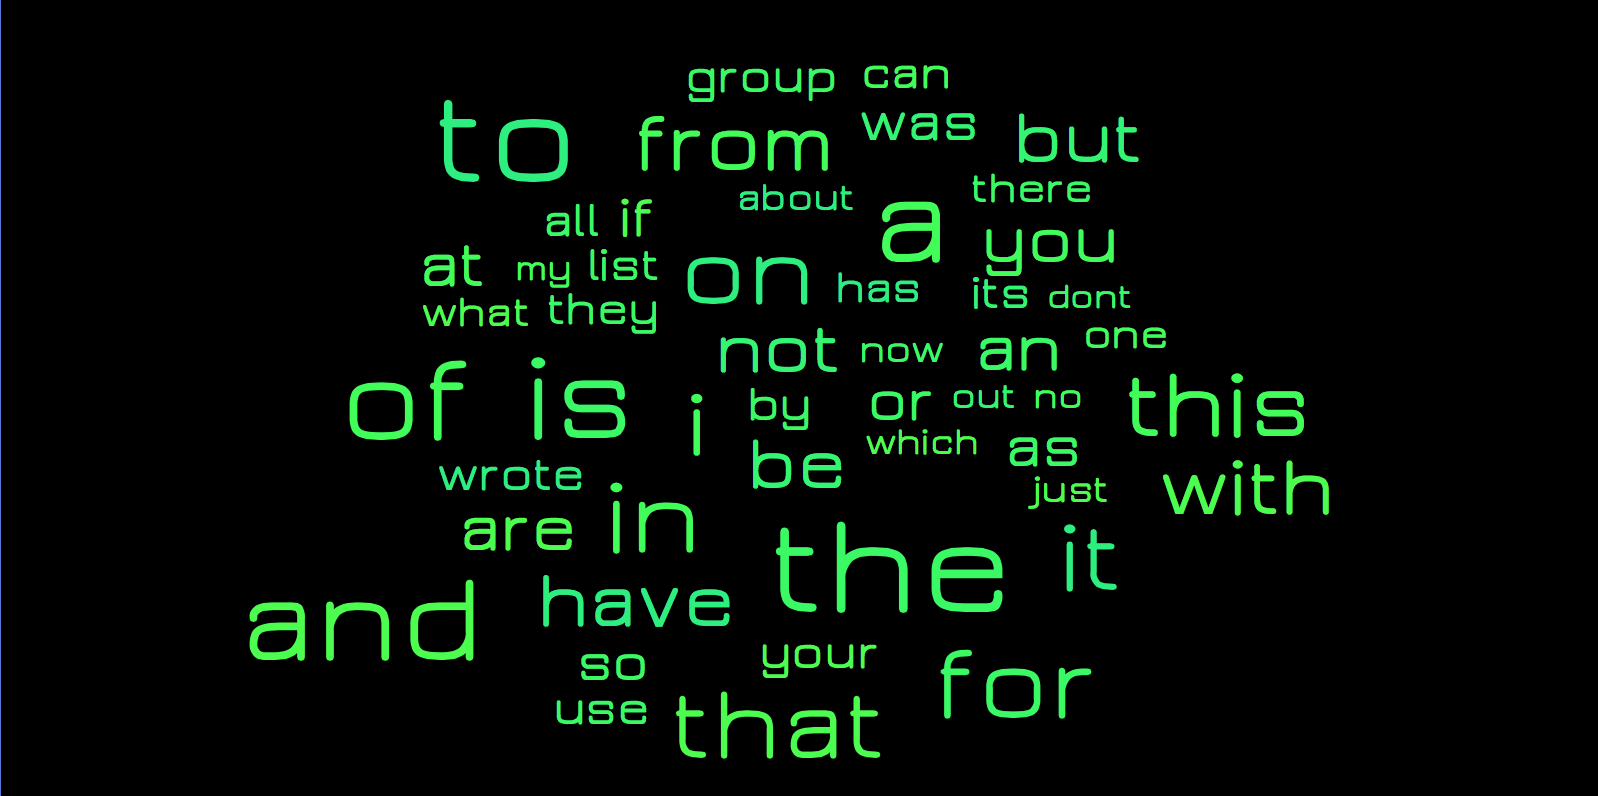

In [17]:
from IPython.display import Image
Image("stop-words.png")

### If we don't remove the stopwords, the most common words will be similar to the image above.

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()

word_tokens = nltk.word_tokenize(cleaned_text)

filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 

lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in filtered_sentence]
print (lemmatized_word)

['seriously', 'worst', 'chipotle', 'ever', 'coming', 'year', 'nnthere', 'must', 'new', 'management', 'staff', 'working', 'recent', 'visit', 'plain', 'stingy', 'one', 'favorite', 'part', 'ordering', 'chipotle', 'duh', 'adding', 'extra', 'item', 'onto', 'plate', 'free', 'except', 'meat', 'guac', 'please', 'explain', 'think', 'okay', 'provide', 'guest', 'extra', 'ingredient', 'standard', 'courtesy', 'throughout', 'location', 'nnsay', 'hello', 'smallest', 'stingiest', 'plate', 'food', 'ever', 'ordered', 'honestly', 'shocked', 'audacity', 'try', 'charge', 'people', 'nnwhile', 'location', 'nestled', 'panda', 'express', 'mcdonald', 'harrah', 'venetian', 'much', 'better', 'walk', 'couple', 'block', 'another', 'location', 'place', 'r', 'h', 'typical', 'chipotle', 'location', 'service', 'attentive', 'efficient', 'line', 'move', 'swiftly', 'even', 'crowded', 'chipotle', 'get', 'fast', 'food', 'star', 'usually', 'huge', 'line', 'feeling', 'cafeteria', 'food', 'enter', 'order', 'food', 'fast', 'ok'

### Frequency distribution of words

In [19]:
freq_dist = nltk.FreqDist(lemmatized_word)
freq_dist

#print(freq_dist["cafeteria"])

FreqDist({'chipotle': 13, 'location': 10, 'time': 9, 'get': 7, 'burrito': 7, 'food': 6, 'salad': 6, 'line': 5, 'bowl': 5, 'salsa': 5, ...})

In [20]:
from collections import Counter 
Counter = Counter(freq_dist)
top_10_words = Counter.most_common(10)
top_10_words = pd.DataFrame(top_10_words)
top_10_words.columns = ["Word","Count"]

In [21]:
top_10_words.head(20)

,Word,Count
0,chipotle,13
1,location,10
2,time,9
3,get,7
4,burrito,7
5,food,6
6,salad,6
7,line,5
8,bowl,5
9,salsa,5


In [22]:
import plotly.express as px

fig = px.bar(top_10_words, x='Word', y='Count', text='Count')
fig.show()

## Question-5
### What’s the percentage of users, who reviewed “Mon Ami Gabi”, and also reviewed at least 10 other restaurants located in Ontario?

In [2]:
import os
import pandas as pd
import math
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_Dataset')

In [3]:
reviews = pd.read_csv("reviews.csv")
business = pd.read_csv("business.csv")

In [4]:
reviews.head()

,Review_id,User_id,business_id,stars,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,IPw8yWiyqnfBzzWmypUHgg,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,If you are looking for the best pierogies in P...,2017-05-13 10:41:43
2,eed44nI0eZ4BGKtKXsRJhQ,tAcB1ZohRtjozsymvqqHzQ,m7ommfJFalI47UksyX04Iw,1.0,Met a friend for dinner there tonight. The ser...,2014-09-25 08:15:44
3,E4LqIZ7DJd_R4ZHSNKx4RQ,DoRCeCcJbrsM2BiAKj3trA,SU56w479vUfFHsvmvQIf7A,4.0,So good! They didn't make it to 5 stars due to...,2016-07-25 03:55:20
4,h7Rmb3EiXjajVfGYNa5CuQ,oAOE4UAC5ZbAjEGBEMCb4g,PycR_Mr5jA9jB4Xg3nX0Yw,1.0,They charged me twice what I expected to pay. ...,2014-01-17 02:15:25


In [5]:
business.head()

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",43.605499,-79.652289
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,170,1,"Sushi Bars, Restaurants, Japanese",35.092564,-80.859132
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,Phoenix,AZ,18,1,"Restaurants, Breakfast & Brunch, Mexican, Taco...",33.495194,-112.028588
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,Mentor-on-the-Lake,OH,16,1,"Italian, Restaurants, Pizza, Chicken Wings",41.708520,-81.359556
4,-K4gAv8_vjx8-2BxkVeRkA,Baby Cakes,Willoughby,OH,7,1,"Bakeries, Food",41.639860,-81.406396


### Let's find out how many users have reviewd Mon Ami Gabi

In [6]:
business[business['name'] == 'Mon Ami Gabi']

,business_id,name,city,state,review_count,is_open,categories,latitude,longitude
31832,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,Las Vegas,NV,8348,1,"Food, French, Breakfast & Brunch, Restaurants,...",36.112859,-115.172434


In [7]:
mon_ami_gabi = reviews[reviews['business_id'] == "4JNXUYY8wbaaDmk3BPzlWw"]
#mon_ami_gabi.to_csv("mon_ami_gabi.csv",index=False)

mon_ami_gabi

,Review_id,User_id,business_id,stars,text,date
101093,BP-Ef0N-DwVzRLOhESrSkw,SIpBqzGhRM7T5cDFiuIryg,4JNXUYY8wbaaDmk3BPzlWw,5.0,"I finally ate here today! For many years, I w...",2013-10-25 02:00:20
101477,lV4-_fa-Xx8ar1Ke80m3Rg,0hMC8tPtc_K_ACAj7pss_Q,4JNXUYY8wbaaDmk3BPzlWw,3.0,"What I loved about this place is that, when I ...",2011-04-25 06:35:05
101487,CgNoFiHxxZE8dn-vULYB9Q,HFECrzYDpgbS5EmTBtj2zQ,4JNXUYY8wbaaDmk3BPzlWw,4.0,"When I'm on a business trip, it's easier to ea...",2012-03-03 00:24:57
101820,z_X2-0bK9K8dUpGHzgsHBg,gDXJ1ES0-IQ_6T7a7oOjwg,4JNXUYY8wbaaDmk3BPzlWw,4.0,"There's a nice evening breeze, you can hear An...",2013-02-23 09:36:48
101921,stKtPWHBi3UCaU88MBWdhQ,DlVTMl3ciFqguGb5hWjswg,4JNXUYY8wbaaDmk3BPzlWw,4.0,"Nice view, decent food (but can be hit or miss...",2014-04-03 10:24:30
...,...,...,...,...,...,...
123052,cmAWxw_cpORuHB9s3Qt2cw,DjiWvNLBbrOI5qKOyYGtCA,4JNXUYY8wbaaDmk3BPzlWw,5.0,I am so happy i found got to try this amazing ...,2012-10-06 16:41:48
123865,a9hEUNGI9A-hgZzki1U2ZA,41HLwXnR0Lm3NUp01cIOQg,4JNXUYY8wbaaDmk3BPzlWw,3.0,Food at Mon Ami Gabi is decent and the view to...,2011-03-15 07:58:48
124679,pj40n3BEe5G7vo5pVocpgA,NE0Mx9NLNUi9eVUpM5v1Gw,4JNXUYY8wbaaDmk3BPzlWw,5.0,Strolled in around 10 AM on a Sunday morning. ...,2014-09-23 22:23:30
124722,HOrSUjqwQq0S1lgRN6rUKw,lxdiwASOCnvRFsogbEYh3A,4JNXUYY8wbaaDmk3BPzlWw,4.0,"This place started on the wrong foot, but once...",2016-10-24 07:39:49


#### 98 users have reviewed restaurant Mon Ami Gabi

### Filtering out all the users who have reviewd in Ontario, Canada

In [8]:
#Readin necessary files
reviews = pd.read_csv("reviews.csv")
business = pd.read_csv("business.csv")
mon_ami_gabi = pd.read_csv("mon_ami_gabi.csv")

#Joining review and business data tables
temp = reviews.merge(business, how='left')

#filtering out reviwes of restaurants located in Ontario, Canada
temp_ontario = temp[temp['state'] == "ON"]

### Value initalization for the number of restraunts a user must have rated

In [9]:
value = 10

### Counting the number of restaurant every user has reviewed in Ontario

In [10]:
temp = temp_ontario.groupby(['User_id']).count()

### Filtering those users who have reviewed more than 10 restaurants

In [11]:
temp = temp[temp['Review_id'] >= value]
temp.reset_index(inplace = True)
temp

,User_id,Review_id,business_id,stars,text,date,name,city,state,review_count,is_open,categories,latitude,longitude
0,--Qh8yKWAvIP4V4K8ZPfHA,10,10,10,10,10,10,10,10,10,10,10,10,10
1,0BBUmH7Krcax1RZgbH4fSA,19,19,19,19,19,19,19,19,19,19,19,19,19
2,0IwZb1ePNpSVYcCdMtGoQw,78,78,78,78,78,78,78,78,78,78,78,78,78
3,0J9mtVJ4_QGsXYVK8qJzOQ,42,42,42,42,42,42,42,42,42,42,42,42,42
4,0w03V5AjlO_EHnRRorlLFQ,14,14,14,14,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,zCnJQKvZgET4llBbJD1aiw,14,14,14,14,14,14,14,14,14,14,14,14,14
229,zLuX_g-whSejuUGTKW8PTw,12,12,12,12,12,12,12,12,12,12,12,12,12
230,zT9WFNJXeQZBA-WJMsV4Zw,11,11,11,11,11,11,11,11,11,11,11,11,11
231,zo2vscKNvDzXWj7YOrdJVA,27,27,27,27,27,27,27,27,27,27,27,27,27


### We got 233 users, now let's see out of this 233 how many of them have rated Mon Ami Gabi

In [12]:

ontario = temp['User_id']
#ontario has users of ontario with more than 10 reviews

mon_users = mon_ami_gabi['User_id']
#mon has users list who have rated mon ami gabi



print("{}% percent of users, who reviewed “Mon Ami Gabi”, and also reviewed at least {} other restaurants located in Ontario\n ".format(math.floor((len(set(mon_users) & set(ontario))) / (mon_ami_gabi['User_id'].nunique()) * 100), value))


0% percent of users, who reviewed “Mon Ami Gabi”, and also reviewed at least 10 other restaurants located in Ontario
 


### We got 0% but if decrease our cut-off value from 10 restaurants to 4 restaurants we get 1% of users

In [13]:
value = 4
temp = temp_ontario.groupby(['User_id']).count()
temp = temp[temp['Review_id'] >= value]
temp.reset_index(inplace = True)

ontario = temp['User_id']
#ontario users

mon_users = mon_ami_gabi['User_id']
#mon_ami_gabi users



print("{}% percent of users, who reviewed “Mon Ami Gabi”, and also reviewed at least {} other restaurants located in Ontario\n ".format(math.floor((len(set(mon_users) & set(ontario))) / (mon_ami_gabi['User_id'].nunique()) * 100), value))


1% percent of users, who reviewed “Mon Ami Gabi”, and also reviewed at least 4 other restaurants located in Ontario
 


# Question-6
### Please think about 2 more analytics, which provide insights for existing/future Business Owners , to make important decisions regarding new business or business expansion.

## Popular cities for a selected category

In [23]:
import os
import nltk
import ipywidgets as widgets

from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_Dataset')

### Select a category:

In [24]:
import ipywidgets as widgets
categories = widgets.ToggleButtons(
    options=['Mexican','Chinese','Italian','Korean'],
    description='Categories:',
)
categories


ToggleButtons(description='Categories:', options=('Mexican', 'Chinese', 'Italian', 'Korean'), value='Mexican')

In [25]:
category = categories.value

### Finding all the restaurants of the category selected.

In [26]:
review = pd.read_csv("reviews.csv")
business = pd.read_csv("business.csv")

data = list()
merged_data = business.merge(review, how='left')
merged_data.head(3)
len(merged_data)
#159,285



try:
    for i in range(len(merged_data)):
        categories = merged_data.iloc[i]['categories']
        categories = categories.replace(" ","")
        categoryList = categories.split(",")
        if category in categoryList:
            data.append(merged_data.iloc[i])
except Exception as e:
    print("***",e)
    #pass
    

test = pd.DataFrame(data, columns=['business_id','name','city','state','review_count','is_open','categories', 'latitude', 'longitude', 'Review_id', 'User_id', 'stars', 'text', 'date'])
del test['date']

check_in = pd.read_csv("check_in_count.csv")
check_in.rename(columns={'date':'checkin_count'}, inplace=True)
test = test.merge(check_in, how='left')
#test.head(3)


In [27]:
test2=test
test2.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)

### Cities with most reviews,check-in, and ratings

In [28]:
most_reviewed_cities = test2[['city', 'review_count','checkin_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum','checkin_count': 'sum', 'stars': 'mean'}).sort_values(by='checkin_count', ascending=False)
most_reviewed_cities.head(10)


,review_count,checkin_count,stars
city,,,
Las Vegas,104999,339944.0,3.399573
Phoenix,71123,186899.0,3.400000
Scottsdale,27317,104787.0,3.105263
Charlotte,16877,46165.0,3.555556
Henderson,12644,44192.0,3.596774
Tempe,10936,38079.0,3.263158
Mesa,13275,37823.0,3.417722
Chandler,11114,34572.0,3.464789
Toronto,17423,23833.0,3.509091


In [29]:
c = most_reviewed_cities
c.reset_index(inplace = True)
c=c[:10]
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Check-in Count', x=c.city, y=c.checkin_count),
    go.Bar(name='Review Count', x=c.city, y=c.review_count)
])
fig.update_layout(barmode='group')
fig.show()


## Select a city to see the top 15 most reviewed business

In [30]:
cities = list()
cities = c['city']

city_selector = widgets.Dropdown(
    options=cities,
    value='Las Vegas',
    description='Number:',
    disabled=False,
)
city_selector

Dropdown(description='Number:', options=('Las Vegas', 'Phoenix', 'Scottsdale', 'Charlotte', 'Henderson', 'Temp…

In [31]:
#Enter city name here
city = city_selector.value

In [32]:
test3 = test2[test2['city'] == city]
#test3.head()

In [33]:
#review count/ check-in count
test3[['name', 'review_count','checkin_count', 'city', 'stars']].sort_values(ascending=False, by=['checkin_count','review_count'])[0:15]

,name,review_count,checkin_count,city,stars
2934,Nacho Daddy,2400,17288.0,Las Vegas,4.0
7806,El Dorado Cantina,2623,11118.0,Las Vegas,5.0
3549,Tacos El Gordo,3243,9526.0,Las Vegas,5.0
3287,Nacho Daddy Downtown,1445,7640.0,Las Vegas,4.0
531,Juan's Flaming Fajitas & Cantina,1624,6557.0,Las Vegas,4.0
2558,Mesa Grill,3268,5847.0,Las Vegas,4.0
1765,KoMex Fusion,1258,5349.0,Las Vegas,3.0
4420,Cabo Wabo Cantina,1312,5320.0,Las Vegas,3.0
6475,Tacos El Gordo,1579,5236.0,Las Vegas,5.0
1004,Border Grill,1623,4856.0,Las Vegas,4.0


## Most common words used in positive reviews and negative reviews

In [34]:
rest_list = list()
for i in range(0,15):
    rest_list.append(test3.iloc[i]['business_id'])

In [35]:
##GET REVIEWS OF TOP 5 RESTAURANT OF TORONTO
res_1 = merged_data[merged_data['business_id'].isin(rest_list)]
print("Number of reviews for top Restaurants: {}".format(len(res_1)))

Number of reviews for top Restaurants: 28


In [36]:
pd.options.display.max_colwidth = 100000

#Negative Reviews
res_1_neg = res_1[res_1["stars"] <=3]
neg_reviews = str(res_1_neg[['text']])

#Positive Reviews
res_1_pos = res_1[res_1["stars"] >3]
pos_reviews = str(res_1_pos[['text']])

#### cleaning text

In [37]:
#Pos Reviews
#Neg Reviews
def top_words(reviews):

    #LOWER
    def to_lower(text):
        return ' '.join([w.lower() for w in nltk.word_tokenize(text)])

    lower = to_lower(reviews)

    #Cleaning
    cleaned_text = re.sub('<[^<]+?\\>','', lower)
    cleaned_text = ''.join(c for c in cleaned_text if not c.isdigit())
    cleaned_text

    def strip_punctuation(s):
        return ''.join(c for c in s if c not in punctuation)

    cleaned_text = strip_punctuation(cleaned_text)

    #is based on The Porter Stemming Algorithm
    #Stop words and Lemmatization
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append("definitely")
    stopwords.append("nt")
    stopwords.append("like")
    stopwords.append("get")
    stopwords.append("mi")
    stopwords.append("good")
    stopwords.append("thought")

    stop_words = set(stopwords)
    word_tokens = nltk.word_tokenize(cleaned_text)

    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in filtered_sentence]
    return (lemmatized_word)

In [38]:
def word_cloud(text):
    import numpy as np
    import pandas as pd
    from os import path
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)
    return(wordcloud)

def word_cloud_neg(text):
    import numpy as np
    import pandas as pd
    from os import path
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="black").generate(text)
    return(wordcloud)

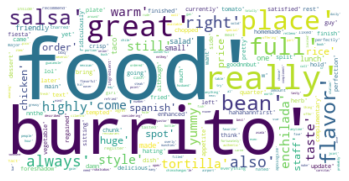

In [39]:
#Text preprocessing
pos = top_words(pos_reviews)
wordcloud = word_cloud(str(pos))

# Generating wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

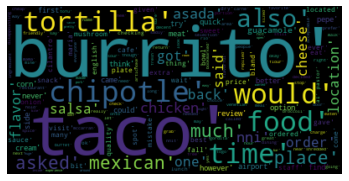

In [40]:
#Text preprocessing
neg = top_words(neg_reviews)
wordcloud = word_cloud_neg(str(neg))

# Generating wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Question - 7: Restaurant Rating Prediction

In [2]:
import nltk
import pandas as pd
import numpy as np
import random
from nltk.corpus import movie_reviews #2000 movie revies 
import pickle
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from nltk.classify import ClassifierI
from statistics import mode
pd.options.display.max_colwidth = 100000
os.chdir('/Users/Diven/Desktop/SMU/Lift & CO/yelp_dataset')
os.getcwd()
import re
from string import punctuation
from nltk.stem import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')

## Data:

In [41]:

df = pd.read_csv('rating_prediction.csv')
df.head()
#248K

,stars,text
0,1,Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.
1,5,"If you are looking for the best pierogies in Pittsburgh, this is your place. There are a few small tables outside but most of the business is carry out. Pierogies Plus wins Best Pierogies every year. Why? Because the owner is from Poland and she is making the real deal pierogies. The best part is that they are hand pinched by a group of older Polish and Hungarian women. \nThe biggest seller is potato and cheese but they sell many flavors. They are like plump pillows of softness. You can buy them buy the dozen. You can get them cold to take home and freeze or warm and ready to eat. The warm ones are served with butter and onions. It's definitely a comfort food. The best part is that they ship internationally. Yes, they are that good."
2,1,"Met a friend for dinner there tonight. The server only brought us one menu. After she brought us a couple of Cokes she didn't come to our table for 20 mins. After trying to get her attention a few times when she walked by we decided to just order off the bartender. We received the starters and the mains at the same time. The wings, brisket, and mac and cheese were alright at best. At this point we hadn't seen the server since she brought the food, so we had to go to the bar for more napkins and refills on the Cokes. The most we actually saw our server was when she hovered over us as we put the tip into the handheld credit card terminal. \n\nFood was somewhere between okay and decent. Service was somewhere between piss poor and terrible."
3,4,"So good! They didn't make it to 5 stars due to the prices are a bit high for the amount of food and the location is a bit unsavory. \nThe decor and atmosphere was surprisingly nice, from the outside I expected to be more run down inside. The staff was very nice. We were surprised how empty the dining room was for a Friday evening.\nWe got Vegetable Samosas to start then ordered Chicken Tikka Masala, Lamb Rogan Josh, rice and plain Naan. Our only complaint was the lamb could've been more tender but everything was flavorful and delicious. \nI would definitely go again if given the chance."
4,1,"They charged me twice what I expected to pay. The guy at the counter small-talked me, asked me if I wanted ""any additional insurance"" - I said no - and just initialed where he told me to, not noticing that one thing I initialed was collision waiver insurance, which I did not need and ended up doubling the original cost. He did not walk me through the additional cost and may even have been purposely misleading by distracting me with small talk. I am an experienced traveler and nothing like this has happened to me before. When I returned the car and expressed my surprise at the doubled cost they essentially said ""well you signed it"" and ""it's worth it anyway."" I will never rent from this Payless again."


## Rating Distribution

In [42]:
df['stars'].unique()

array([1, 5, 4, 3, 2])

In [43]:
t = df['stars'].value_counts()
t= pd.DataFrame(t)
t.reset_index(inplace = True)
t.columns = ['rating','count']

import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(t, x='rating', y='count', text='count')
fig.show()

## Downsampling

In [47]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority_1 = df[df.stars==1]
df_minority_2 = df[df.stars==2]
df_majority_3 = df[df.stars==3]
df_majority_4 = df[df.stars==4]
df_majority_5 = df[df.stars==5]
 

# Downsample majority class
df_majority_downsampled_1 = resample(df_majority_1, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority_2),     # to match minority class
                                 random_state=123) # reproducible results

df_majority_downsampled_3 = resample(df_majority_3, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority_2),     # to match minority class
                                 random_state=123) # reproducible results

df_majority_downsampled_4 = resample(df_majority_4, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority_2),     # to match minority class
                                 random_state=123) # reproducible results

df_majority_downsampled_5 = resample(df_majority_5, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority_2),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled_1, df_minority_2, df_majority_downsampled_3, df_majority_downsampled_4, df_majority_downsampled_5])
 
# Display new class counts
df_downsampled.stars.value_counts()
df = df_downsampled


In [48]:
t = df['stars'].value_counts()
t= pd.DataFrame(t)
t.reset_index(inplace = True)
t.columns = ['rating','count']

import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(t, x='rating', y='count', text='count')
fig.show()

## Data Preperation

### Splitting up all the reviews and saving it in a file

In [7]:
temp = df[df['stars'] == 1]
del temp['stars']
temp = temp.to_numpy()
np.savetxt('one.txt', temp, fmt='%s') 

temp = df[df['stars'] == 2]
del temp['stars']
temp = temp.to_numpy()
np.savetxt('two.txt', temp, fmt='%s') 

temp = df[df['stars'] == 3]
del temp['stars']
temp = temp.to_numpy()
np.savetxt('three.txt', temp, fmt='%s') 

temp = df[df['stars'] == 4]
del temp['stars']
temp = temp.to_numpy()
np.savetxt('four.txt', temp, fmt='%s') 

temp = df[df['stars'] == 5]
del temp['stars']
temp = temp.to_numpy()
np.savetxt('five.txt', temp, fmt='%s') 


In [8]:
one = open("one.txt","r").read()
two = open("two.txt","r").read()
three = open("three.txt","r").read()
four = open("four.txt","r").read()
five = open("five.txt","r").read()

### Merging all the reviews

In [9]:
documents = []
for r in one.split('\n'):
  documents.append((r,"1"))
    
for r in two.split('\n'):
    documents.append((r,"2"))
    
for r in three.split('\n'):
    documents.append((r,"3"))
    
for r in four.split('\n'):
    documents.append((r,"4"))
    
for r in five.split('\n'):
    documents.append((r,"5"))

### Tokenization

In [10]:
from nltk.tokenize import word_tokenize
all_words = []

one = word_tokenize(one)
two = word_tokenize(two)
three = word_tokenize(three)
four = word_tokenize(four)
five = word_tokenize(five)

for w in one:
    all_words.append(w)
    
for w in two:
    all_words.append(w)
    
for w in three:
    all_words.append(w)
    
for w in four:
    all_words.append(w)
    
for w in five:
    all_words.append(w)

### Cleaning 

In [11]:
def clean_text(reviews):

    #LOWER
    def to_lower(text):
        return ' '.join([w.lower() for w in nltk.word_tokenize(text)])

    lower = to_lower(reviews)

    #Cleaning
    cleaned_text = re.sub('<[^<]+?\\>','', lower)
    cleaned_text = ''.join(c for c in cleaned_text if not c.isdigit())
    cleaned_text

    def strip_punctuation(s):
        return ''.join(c for c in s if c not in punctuation)

    cleaned_text = strip_punctuation(cleaned_text)

    stopwords = nltk.corpus.stopwords.words('english')

    stop_words = set(stopwords)
    word_tokens = nltk.word_tokenize(cleaned_text)

    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in filtered_sentence]
    return (lemmatized_word)

In [12]:
all_words = clean_text(str(all_words))

all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())[:4000]

### Creating dictionary of top words for every review

In [ ]:
def find_features(document):
    words = word_tokenize(document) 
    features = {}
    for w in word_features:
        features[w] = (w in words) 
    
    return features


#random.shuffle(documents)
documents = documents[:40000]


featuresets = [(find_features(rev), category) for(rev, category) in documents]

random.shuffle(featuresets)


## Model execution

### Splitting the dataset into training and testing - 80 : 20

In [ ]:
training_set = featuresets[:86000]
testing_set = featuresets[86000:] 

### Naive Bayes

In [159]:

classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Naive Bayes Algo accuracy:", (nltk.classify.accuracy(classifier, testing_set ))*100)


Naive Bayes Algo accuracy: 56.49999999999999


### Logistic Regression

In [157]:

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set ))*100)


LogisticRegression_classifier accuracy: 57.440000000000005


### Support Vector Classifier

In [163]:

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set)
print("SVC_classifier accuracy:", (nltk.classify.accuracy(SVC_classifier, testing_set ))*100)


SVC_classifier accuracy: 52.839999999999996


### Ensembling All The Trained Models

In [165]:
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

In [171]:

voted_classifier = VoteClassifier(classifier,
                                  LogisticRegression_classifier,
                                  SVC_classifier)


print("voted_classifier accuracy:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)


voted_classifier accuracy: 58.14


### Random Forest Classifier

In [158]:

rf_classifier = SklearnClassifier(RandomForestClassifier())
rf_classifier.train(training_set)
print("rf_classifier accuracy:", (nltk.classify.accuracy(rf_classifier, testing_set ))*100)


rf_classifier accuracy: 55.16


### Random forest is an ensemble model so didn't merged with the above models.

### Rest of the solutions are in colab notebook:
https://colab.research.google.com/drive/1YX3KbvUuWFzJUG7GeM03tQOFsYA0oFS7


In [ ]:
----------------------------------------------   COLAB   -------------------------------------------------------------